In [81]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn

from typing import List, Union

In [82]:
def scaled_erf_activation(x):
    return torch.erf(x / np.sqrt(2))

## Network Classes

In [83]:
class TeacherNetwork(nn.Module):
    
    def __init__(
        self, 
        input_dimension: int, 
        output_dimension: int,
        teacher_hidden_dimension: int, 
        teacher_initialisation_std: float, 
        teacher_hidden_scaling: bool, 
        teacher_forward_scaling: bool,
        unit_norm_teacher_head: bool
    ):
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
        self._teacher_hidden_dimension = teacher_hidden_dimension
        self._teacher_initialisation_std = teacher_initialisation_std
        self._unit_norm_teacher_head = unit_norm_teacher_head
        
        if teacher_hidden_scaling:
            self._hidden_scaling = 1 / np.sqrt(input_dimension)
        else:
            self._hidden_scaling = 1.
            
        if teacher_forward_scaling:
            self._forward_scaling = 1 / np.sqrt(teacher_hidden_dimension)
        else:
            self._forward_scaling = 1.
        
        self._activation = scaled_erf_activation
        
        super().__init__()
        
        self._construct_layers()
        
    def _construct_layers(self):
        
        self._layer1 = nn.Linear(self._input_dimension, self._teacher_hidden_dimension, bias=False)
        self._layer2 = nn.Linear(self._teacher_hidden_dimension, self._output_dimension, bias=False)
        
        nn.init.normal_(self._layer1.weight, std=self._teacher_initialisation_std)
        
        if self._unit_norm_teacher_head:
            head_norm = torch.norm(self._layer2.weight)
            normalised_head = self._layer2.weight / head_norm
            self._layer2.weight.data = normalised_head
            
        else:
            nn.init.normal_(self._layer2.weight, std=self._teacher_initialisation_std)
            
        for param in self.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x = self._activation(self._hidden_scaling * self._layer1(x))
        y = self._forward_scaling * self._layer2(x)
        return y

In [84]:
class DeepStudentNetwork(nn.Module):
    
    def __init__(
        self, 
        input_dimension: int, 
        output_dimension: int,
        student_hidden_dimension: int, 
        student_initialisation_std: float, 
        student_hidden_scaling: bool, 
        student_forward_scaling: bool,
    ):
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
        self._student_hidden_dimension = student_hidden_dimension
        self._student_initialisation_std = student_initialisation_std
        
        if student_hidden_scaling:
            self._hidden_scaling = 1 / np.sqrt(input_dimension)
        else:
            self._hidden_scaling = 1.
            
        if student_forward_scaling:
            self._forward_scaling = 1 / student_hidden_dimension
        else:
            self._forward_scaling = 1.
            
        self._activation = scaled_erf_activation
        
        super().__init__()
    
        self._construct_layers()
        
    def _construct_layers(self):
        
        self._layer1 = nn.Linear(self._input_dimension, self._student_hidden_dimension, bias=False)
        
        nn.init.normal_(self._layer1.weight, std=self._student_initialisation_std)
        
        self._heads = nn.ModuleList()
        
        head1 = nn.Linear(self._student_hidden_dimension, self._output_dimension, bias=False)
        head2 = nn.Linear(self._student_hidden_dimension, self._output_dimension, bias=False)
        
        nn.init.normal_(head1.weight, std=self._student_initialisation_std)
        nn.init.normal_(head2.weight, std=self._student_initialisation_std)

        self._heads.append(head1)
        self._heads.append(head2)
            
    def switch(self, index: int):
        self._active_head_index = index
        inactive_head_index = int(not index)
        for param in self._heads[inactive_head_index].parameters():
            param.requires_grad = False
        for param in self._heads[index].parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self._activation(self._hidden_scaling * self._layer1(x))
        y = self._forward_scaling * self._heads[self._active_head_index](x)
        return y
    
    def forward_all(self, x):
        x = self._activation(self._hidden_scaling * self._layer1(x))
        ys = [self._forward_scaling * head(x) for head in self._heads]
        return ys

In [85]:
class OneLayerStudentNetwork(nn.Module):
    
    def __init__(
        self, 
        input_dimension: int, 
        output_dimension: int,
        student_initialisation_std: float, 
        student_hidden_scaling: bool, 
        activate: bool
    ):
        
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
        self._student_initialisation_std = student_initialisation_std
        
        if student_hidden_scaling:
            self._hidden_scaling = 1 / np.sqrt(input_dimension)
        else:
            self._hidden_scaling = 1.
            
        self._activation = scaled_erf_activation
        self._activate = activate
        
        super().__init__()
    
        self._construct_layers()
        
    def _construct_layers(self):
        
        self._heads = nn.ModuleList()
        
        head1 = nn.Linear(self._input_dimension, self._output_dimension, bias=False)
        head2 = nn.Linear(self._input_dimension, self._output_dimension, bias=False)
        
        nn.init.normal_(head1.weight, std=self._student_initialisation_std)
        nn.init.normal_(head2.weight, std=self._student_initialisation_std)

        self._heads.append(head1)
        self._heads.append(head2)
            
    def switch(self, index: int):
        self._active_head_index = index
        inactive_head_index = int(not index)
        for param in self._heads[inactive_head_index].parameters():
            param.requires_grad = False
        for param in self._heads[index].parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self._hidden_scaling * self._heads[self._active_head_index](x)
        if self._activate:
            y = self._activation(x)
        else:
            y = x
        return y
    
    def forward_all(self, x):
        xs = [self._hidden_scaling * head(x) for head in self._heads]
        if self._activate:
            ys = [self._activation(x) for x in xs]
        else:
            ys = xs
        return ys

## Trainer Class

In [86]:
class Trainer:
    
    def __init__(
        self, 
        teachers: List[TeacherNetwork], 
        student: Union[DeepStudentNetwork, OneLayerStudentNetwork], 
        lr: float, 
        test_data: torch.Tensor,
        verbose: bool = False
    ):
        self._teachers = teachers
        self._student = student
        
        self._verbose = verbose
        
        self._loss_function = nn.MSELoss()
        self._optimiser = torch.optim.SGD(self._student.parameters(), lr=lr)
        
        self._test_data = test_data
        
        self._test_teacher_output = [teacher(self._test_data) for teacher in self._teachers]
        
        self._test_loss_teacher_0 = []
        self._test_loss_teacher_1 = []
        
    @property
    def test_losses(self):
        return self._test_loss_teacher_0, self._test_loss_teacher_1

    def train(
        self, 
        num_steps: int, 
        switch_steps: List[int],
        test_frequency: int
    ):    
        switch_step_generator = iter(switch_steps)

        try:
            next_switch_step = next(switch_step_generator)
        except StopIteration:
            next_switch_step = np.inf

        teacher_index = 0
        self._student.switch(teacher_index)

        for i in range(num_steps):

            if i % test_frequency == 0:
                with torch.no_grad():

                    test_student_outputs = self._student.forward_all(self._test_data)

                    test_loss = [
                        self._loss_function(student_output, teacher_output).item() 
                        for student_output, teacher_output in zip(test_student_outputs, self._test_teacher_output)
                    ]
                    self._test_loss_teacher_0.append(test_loss[0])
                    self._test_loss_teacher_1.append(test_loss[1])

            if i == next_switch_step:
                teacher_index = int(not teacher_index)
                self._student.switch(teacher_index)
                try:
                    next_switch_step = next(switch_step_generator)
                except StopIteration:
                    next_switch_step = np.inf

            if self._verbose and i % 500 == 0 and i != 0:
                print(f"step {i}. Latest errors = {test_loss}")

            data = torch.from_numpy(np.random.normal(size=(1, input_dimension))).to(torch.float32)

            teacher_output = self._teachers[teacher_index](data)
            student_output = self._student(data)

            loss = self._loss_function(student_output, teacher_output)

            self._optimiser.zero_grad()
            loss.backward()
            self._optimiser.step()

## Params

In [87]:
input_dimension = 15
teacher_hidden_dimension = 500
student_hidden_dimension = 1000
output_dimension = 1

teacher_hidden_scaling = True
student_hidden_scaling = True

teacher_forward_scaling = True
student_forward_scaling = True

unit_norm_teacher_head = False
teacher_initialisation_std = 1
student_initialisation_std = 0.001

num_steps = 200000
two_layer_lr = 5
one_layer_lr = 0.0001
test_frequency = 100

test_set_size = 20000

switch_steps = []

In [88]:
test_data = torch.randn((test_set_size, input_dimension))

In [89]:
teachers = [
    TeacherNetwork(input_dimension=input_dimension, output_dimension=output_dimension, teacher_hidden_dimension=teacher_hidden_dimension, teacher_initialisation_std=teacher_initialisation_std, teacher_hidden_scaling=teacher_hidden_scaling, teacher_forward_scaling=teacher_forward_scaling, unit_norm_teacher_head=unit_norm_teacher_head),
    TeacherNetwork(input_dimension=input_dimension, output_dimension=output_dimension, teacher_hidden_dimension=teacher_hidden_dimension, teacher_initialisation_std=teacher_initialisation_std, teacher_hidden_scaling=teacher_hidden_scaling, teacher_forward_scaling=teacher_forward_scaling, unit_norm_teacher_head=unit_norm_teacher_head)
]

In [103]:
# deep_student = DeepStudentNetwork(input_dimension=input_dimension, output_dimension=output_dimension, student_hidden_dimension=student_hidden_dimension, student_initialisation_std=student_initialisation_std, student_hidden_scaling=student_hidden_scaling, student_forward_scaling=student_forward_scaling)
linear_one_layer_student = OneLayerStudentNetwork(input_dimension=input_dimension, output_dimension=output_dimension, student_initialisation_std=student_initialisation_std, student_hidden_scaling=False, activate=False)
nonlinear_one_layer_student = OneLayerStudentNetwork(input_dimension=input_dimension, output_dimension=output_dimension, student_initialisation_std=student_initialisation_std, student_hidden_scaling=False, activate=True)

In [104]:
# deep_student_trainer = Trainer(teachers=teachers, student=deep_student, lr=two_layer_lr, test_data=test_data, verbose=True)
linear_one_layer_student_trainer = Trainer(teachers=teachers, student=linear_one_layer_student, lr=one_layer_lr, test_data=test_data)
nonlinear_one_layer_student_trainer = Trainer(teachers=teachers, student=nonlinear_one_layer_student, lr=one_layer_lr, test_data=test_data)

In [105]:
# deep_student_trainer.train(num_steps=1000000, switch_steps=switch_steps, test_frequency=test_frequency)
linear_one_layer_student_trainer.train(num_steps=1000000, switch_steps=switch_steps, test_frequency=test_frequency)
nonlinear_one_layer_student_trainer.train(num_steps=1000000, switch_steps=switch_steps, test_frequency=test_frequency)

<ipython-input-106-4f435e9233d7>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


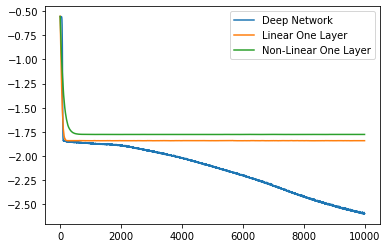

In [106]:
fig = plt.figure()
plt.plot(range(len(deep_student_trainer.test_losses[0])), np.log10(deep_student_trainer.test_losses[0]), label="Deep Network")
plt.plot(range(len(linear_one_layer_student_trainer.test_losses[0])), np.log10(linear_one_layer_student_trainer.test_losses[0]), label="Linear One Layer")
plt.plot(range(len(nonlinear_one_layer_student_trainer.test_losses[0])), np.log10(nonlinear_one_layer_student_trainer.test_losses[0]), label="Non-Linear One Layer")
plt.legend()
fig.show()

<ipython-input-99-969105e6b3eb>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(range(len(deep_student_trainer.test_losses[0]))), np.log10(deep_student_trainer.test_losses[0]), label="Deep Network")
<ipython-input-99-969105e6b3eb>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(range(len(linear_one_layer_student_trainer.test_losses[0]))), np.log10(linear_one_layer_student_trainer.test_losses[0]), label="Linear One Layer")
<ipython-input-99-969105e6b3eb>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(range(len(nonlinear_one_layer_student_trainer.test_losses[0]))), np.log10(nonlinear_one_layer_student_trainer.test_losses[0]), label="Non-Linear One Layer")
<ipython-input-99-969105e6b3eb>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


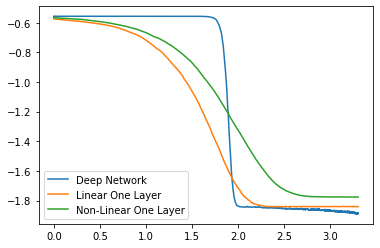

In [99]:
fig = plt.figure()
plt.plot(np.log10(range(len(deep_student_trainer.test_losses[0]))), np.log10(deep_student_trainer.test_losses[0]), label="Deep Network")
plt.plot(np.log10(range(len(linear_one_layer_student_trainer.test_losses[0]))), np.log10(linear_one_layer_student_trainer.test_losses[0]), label="Linear One Layer")
plt.plot(np.log10(range(len(nonlinear_one_layer_student_trainer.test_losses[0]))), np.log10(nonlinear_one_layer_student_trainer.test_losses[0]), label="Non-Linear One Layer")
plt.legend()
fig.show()

<ipython-input-14-0c4f9cc8e567>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


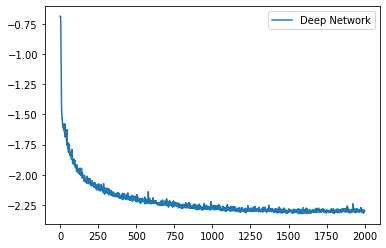

In [14]:
fig = plt.figure()
plt.plot(range(len(deep_student_trainer.test_losses[0])), np.log10(deep_student_trainer.test_losses[0]), label="Deep Network")
plt.legend()
fig.show()